# Galaxies and the large-scale structure of the Universe

In this Notebook, you will use data from the Sloan Digital Sky Survey (SDSS), to explore the relationship between galaxy properties and the large-scale structure of the Universe and measure a basic correlation function. 

_This python exercise notebook written by Karen Masters, March 2024 for ASTR352, Haverford College. Largely based on a [notebook by Rita Tojeiro, October 2017](https://github.com/ritatojeiro/SDSSEPO/blob/master/AS1001_SDSSEPO.ipynb), for the Lab component of the AS1001 Cosmology module at the University of St Andrews, UK. It has been slightly modified to stand alone in an SDSS EPO workshop at AAS. 
This notebook has benefited from examples provided by Britt Lundgren (University of North Carolina) and Jordan Raddick (John Hopkins University). The latter parts are based on a [two-point correlation functions tutorial by Javier Sanchez](https://github.com/fjaviersanchez/corrfunc_tutorial) found on Github which works through this statistical method using the SDSS data._  

In the end, you should have found an answer to the following questions:

- How are galaxies spatially distributed in the Universe?
- How are galaxies' colours and shapes (morphologies) related to their spatial distribution?
- How can we characterize the distribution of galaxies using statistics to measure a correlation function?  

## SDSS and SciServer

You will answer the above questions yourself, by exploring the largest astronomical dataset in the world - the Sloan Digital Sky Survey (www.sdss.org).

You will interact directly with the data using SciServer. SciServer is a cloud-based computing service, that allows users to query the SDSS database, store data in the cloud, and offers seamless integration with python programming tools via notebooks. In practice, this means that you can access and manipulate the largest astronomical dataset in the world, using only a web browser.

If you're reading this, you have already followed the instructions to get an account on SciServer, and have uploaded this notebook. These exercise assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands.




### Imports

Firstly, we will import the necessary SciServer and support libraries. 

In [1]:
# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive as SciDrive   # read/write to/from SciDrive
import SciServer.SkyServer as SkyServer   # show individual objects and generate thumbnail images through SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                  # standard Python lib for math ops
#from scipy.misc import imsave       # save images as files
import pandas                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import os                           # manage local files in your Compute containers
print('Supporting libraries imported')

from astropy.io import ascii

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', None)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

SciServer libraries imported
Supporting libraries imported
Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. SQL is a languased used to communicate with databases via "queries". For each query command, the database returns an answer. Usually, this is a subsample of the original database, though SQL can operate on the data very effectively too. In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: http://skyserver.sdss.org/dr14/en/help/howto/search/searchhowtohome.aspx . In short, every SQL command consists of three blocks: 
- The **SELECT** block: it defines the quantities that you want your query to return.
- The **FROM** block: it defines which tables of the database you want SQL to look in.
- The **WHERE** block: it defines any constraints on the data that you want to impose.

In this Lab you won't have to write SQL queries from scratch, only execute commands that are already written for you.

### Using SQL and SciServer to return galaxy data

For the database schema and documentation see http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx The following query returns specific information on a sample of galaxies, as a dataframe.


In [29]:
# Find objects in the Sloan Digital Sky Survey's Data Release 14.
#
# Query the Sloan Digital Sky Serveys' Data Release 14.
# For the database schema and documentation see http://skyserver.sdss.org/dr14
#
# This query finds all galaxies with a size (petror90_r) greater than 10 arcseconds, within
# a region of sky with 100 < RA < 250, a redshift between 0.02 and 0.5, and a g-band magnitude brighter than 17.
# 
# First, store the query in an object called "query"
query="""
SELECT p.objId,p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.5
  and p.g < 17
"""
#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print("SQL query returned " + str(len(all_gals))+ " galaxies")

SQL query finished.
SQL query returned 40332 galaxies


The dataframe that is returned, which we named all_gals, holds the following quantities (in columns) for each galaxy:

- ra = Right Ascension coordinate in degrees
- dec = Declination coordinate in degrees
- petror90_r = Radius enclosing 90% of the pertrosian flux in arcseconds. I.e., size of the galaxy in the sky.
- dered_u, dered_g, dered_r, dered_i, dered_z = Magnitudes in 5 optical filters, from the blue to the red, after subtracting the attenuation due to the Milky Way.
- z = Redshift of the galaxy
- plate = Plate number (SDSS used alluminium plates with drilled holes for positioning optical fibers).
- mjd = Date of the observation (as a "Modified Julian Date")
- fiberid = Number of the fiber in a given plate. Plates have between 640 and 1000 fibers.

Let's have a look at the first 10 elements of the returned table (dataframe):

In [30]:
all_gals[0:10]

,objId,ra,dec,petror90_r,expAB_r,u,g,r,i,z,plate,mjd,fiberid
0,1237657612333678757,155.193465,53.968648,18.15203,0.354836,17.55692,15.72920,14.79719,14.27560,0.032995,6696,56398,414
1,1237657612333678804,155.221744,54.087323,11.72348,0.219439,18.68082,16.70114,15.78556,15.26598,0.062532,904,52381,548
2,1237657612333875285,155.876147,54.298719,10.91693,0.205746,18.35515,16.55956,15.89451,15.51757,0.032168,904,52381,563
3,1237657612334661765,158.666120,54.837084,11.86597,0.817067,17.25604,15.59504,14.82547,14.45289,0.065150,905,52643,514
4,1237657612336169050,164.303050,56.179795,10.43556,0.183993,18.33171,16.74023,15.95585,15.49596,0.069171,907,52373,548
5,1237657612336365726,165.217519,56.304490,34.11673,0.808140,18.14336,16.54853,15.67900,15.29074,0.123351,907,52373,589
6,1237657612336365727,165.229213,56.302119,20.11482,0.691980,17.47118,16.58385,16.20198,15.85931,0.124210,908,52373,436
7,1237657612336693293,166.403398,56.524923,31.88202,0.892925,15.21905,13.61925,12.86550,12.47357,0.027353,907,52373,619
8,1237657612337086569,167.967985,56.660762,10.36851,0.827352,17.61095,16.66162,16.43361,16.21732,0.047266,908,52373,560
9,1237657612337086585,168.072258,56.582204,11.87016,0.461280,17.71579,15.63742,14.84392,14.43659,0.044817,909,52379,399


## The large scale structure of the Universe 

### Exercise:

1. Plot the positions of all galaxies usint plt.scatter(). Remember to add labels and a title to your plot. Given the large number of points, you might want to use marker='.' and s=1.

2. What can you tell from the distribution of galaxies? Are they uniformly distributed on the sky?

Answer to question 2: 

### Exercise: 

Using the np.where() command, select galaxies in two narrow redshift slices:
- slice 1: 0.02 < z < 0.03 (green)
- slice 2: 0.03 < z < 0.04 (orange)

Make the same plot as above, but only using the galaxies in each slice using the suggested colour scheme (make one plot for each slice). Finally, make a third plot with galaxies from both redshift slices. Add axis labels, a title and an legend to each plot.


### Exercise:

Do you see more structure in the distribution of galaxies in each slice, when compared to your first plot that included all galaxies? 

What can you tell about the structure you see in the two different redshift slices?

Why couldn't you see it in your first plot?

Answer to above

## Galaxy colours

You will see in lectures that the optical colours of galaxies are related to the age of their stars - red galaxies hold older (redder, cooler) stars, whereas blue galaxies tend to have younger (bluer, hotted) stars. In practice, we can quantify "colour" in Astronomy as _the difference in magnitude in two different bands_.

The final exercises in the first notebook (SciServerLab_session1) give you a demonstration of how colours work in practice, and how the shape of the spectrum of a galaxy. Redshift can also affect the observed colour of galaxies (you will learn this in the later lectures, if you haven't yet), but at these small redshifts it won't be a big factor. 

In this set of exercises **we will focus on the first slice in redshift**, which is very narrow, meaning that all galaxies have a similar redshift. I.e., if galaxies in this redshift slice have different colours, _it ought to be because their spectra and stellar composition are different_, and not because some are redshifted due to the expansion of the Universe. 

The following cell plots a histogram of the values of the **u-g colour** of the galaxies in your dataframe:

Text(0.5, 1.0, 'Distribution of u-g color in 0.02 < z < 0.03')

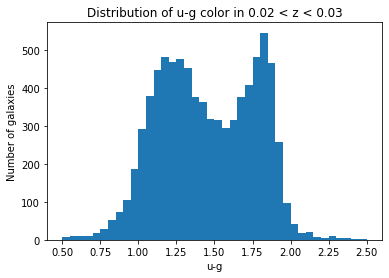

In [37]:
slice1 = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]

plt.hist(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], bins=40, range=(0.5,2.5))
plt.xlabel('u-g')
plt.ylabel('Number of galaxies')
plt.title('Distribution of u-g color in 0.02 < z < 0.03')

**np.percentile()** (https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) allows you to quickly return the percentile of a distribution of points. For example, to find the median (50th percentile) u-g colour of your galaxy population you can write:

In [38]:
median_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 50)
print(median_umg)

1.4351650000000005


i.e., 50% of the galaxies in your sample have u-g colours that are lower than median_umg (i.e., they are bluer than the median), and 50% have  colours that are larger (i.e., they are redder than the median). If I wanted to choose only the 10% reddest galaxies I could do:

In [39]:
high_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 90)

very_red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > high_umg))

### Exercise:

Use np.percentile() to choose the 25% reddest and 25% bluest galaxies in u-g. Then plot their positions on the sky. Do both types of galaxies trace the large-scale structure in a similar way? What can you say about which galaxies preferencially sit on denser parts of the Universe, and which sit on less dense regions (we call this _environment_)? For this exercise it is recommended that you make two plots (one for the red galaxies, and one for the blue), but that you put them side by side to help you compare.


By now you will have started developing an understanding of how galaxies in general are spacially distributed in the Universe and the shape of the cosmic web, and how galaxies' position on the cosmic web and their environment is related to their colour. Next, we will look at the **shape** of galaxies.

## Morphology and environment

Finally, we will explore the **relationship between morphology and environment**. It is extraordinarily difficult to write a computer programme that determines whether a galaxy has spiral structure or is smooth. To this day, the human eye does better than the most sophisticated algorithms (the reason behind projects such as Galaxy Zoo - https://www.galaxyzoo.org). 

We can query for Galaxy Zoo vote fractions (the fraction of people who saw a specific feature) right from CasJobs as below. Here we will use p_el_debiased from the first phase of Galaxy Zoo. Roughly speaking there were only two options in tat phase - spiral, or elliptical. So p_spiral = 1 - p_el_debiased 

In [42]:
query="""
SELECT p.objId, p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid, n.p_el_debiased
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
   JOIN zooSpec AS n ON n.objid = p.objid
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.03
  and p.g < 17
"""
all_gals = CasJobs.executeQuery(query, "dr14")
print(" Query returns " + str(len(all_gals))+ " galaxies")

 Query returns 7874 galaxies



Below is a histogram of the values of the "debiased vote fraction for elliptical galaxies" in our sample. Let us call galaxies with a very high vote fraction ellipticals (p>0.8), and a very low vote fraction, spirals (p < 0.2).

Text(0.5, 1.0, 'Distribution of Galaxy Zoo votes')

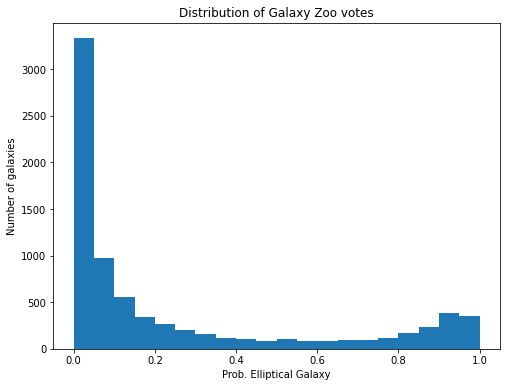

In [44]:
plt.figure(figsize=(8,6))
plt.hist(all_gals['p_el_debiased'], bins=20)
plt.xlabel('Prob. Elliptical Galaxy')
plt.ylabel('Number of galaxies')
plt.title('Distribution of Galaxy Zoo votes')

### Exercise:

Now plot the positions of low and high probability elliptical galaxies, side by side as you did for blue and red galaxies. In your opinion, do you have enough information to determine what property galaxy density influences the most (colour or morphology)? You are encouraged to experiment with different definitions of colour and morphology if you wish, or indeed make an argument as to why your exploration is insuffiencent to answer such a question. 

## Measuring the Correlation Function

Now we will explore how to measure the correlation of function of galaxy positions in these data. This part of the Notebook is largely based on [Javier Sanchez's Correlation Function Tutorial from 2020](https://github.com/fjaviersanchez/corrfunc_tutorial/tree/master). 

Correlation functions roughly speaking, describe the excess probability over random that you will find two galaxies with some separation "s". So when measuring this, it's always done related to a random sample designed to have the same "edges" (in sky co-ordinates and redshift) as the real sample. 

To get some intuition for this let's start by looking at the correlation of function of a completely random distribution of points. And first need to generate that distribution. 

In [48]:
Nrnd = 10000
x = -1+2*np.random.random(size=Nrnd)
y = -1+2*np.random.random(size=Nrnd)

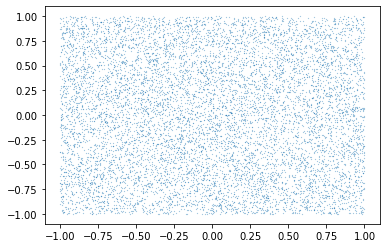

In [49]:
plt.scatter(x,y, s=0.1, marker='.')

In an area of sky, $dA$ the average number of particles will be 
$N(dA)=\rho dA$, 
with $\rho = N_{tot}/A_{tot} = 10,000/4$ for the example above

So in any point in this square, sufficiently away from the edge, we can select a circle of radius $r$ and the number of particles inside of that circle will be: $N(r) = \rho \pi r^{2}$ (since $\pi r^{2}$ is the area of the circle).

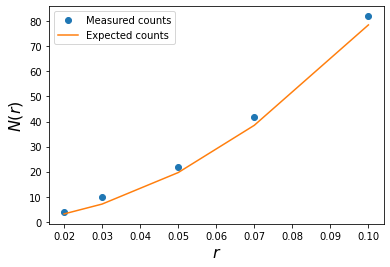

In [50]:
# Let's count in different circles centered at 0,0

#define our variables
r = np.array([0.02, 0.03, 0.05, 0.07, 0.1]) #various sizes of circles
n_r = [] #a variable into which we will count particles
side=2 #size of our box
Atot = side**2 #total area of our box
rho = Nrnd/Atot #overall number density in the box

#now plot!
for i in range(len(r)):
    n_r.append(np.count_nonzero((x**2+y**2) < r[i]**2)) # x**2+y**2 is the distance to the center! 
    #print(n_r[i])
plt.plot(r, n_r, 'o', label='Measured counts')
plt.plot(r, rho*np.pi*r**2, label='Expected counts')
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$N(r)$', fontsize=16)
plt.legend(loc='best')

So, if for every particle we measure the distance with its neighbors, and then count the number of pairs within a certain distance we get that 

$N_{pairs}(r) = \rho \pi r^{2}$, 

and the number of neighbors between $r$ and $r+dr$ will be

$N_{pairs} (r, r+dr) = \rho \pi ((r+dr)^{2}-r^{2})$ 

(area of the big circle with radius $r+dr$ minus the area of the small circle of radius $r$). The total number of pairs will be 

$N_{pairs, tot} (r, r+dr) = N_{tot}\rho \pi ((r+dr)^{2}-r^{2})$ (we'll call this equation 1 below)

In [51]:
# So now, let's compute the distance between each particle and every other particle in our random sample
# (note that we are avoiding double counting by only counting the pair the first time it appears)
distances = []
for i in range(x.size): #AKA for each particle in the box
    distances.append(np.sqrt((x[i+1:]-x[i])**2+(y[i+1:]-y[i])**2))  #measure distance to all particles with a larger index value
    
# Distances is going to be a list of lists, so....

In [52]:
distances = np.concatenate(distances) # We convert to a single list

Text(0, 0.5, '$N_{pairs}$')

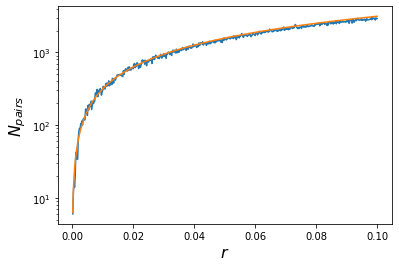

In [53]:
#Now compare to expected distribution for a random sample

hist, be = np.histogram(distances, range=(0,0.1), bins=500) #Make a histogram of the separations
sep_dist = 0.5*(be[1:]+be[:-1]) # Put the plotting point in the center of each bin
dsep = sep_dist[1]-sep_dist[0] 

N_dist = Nrnd*rho*np.pi*(2*sep_dist*dsep+dsep**2) #This is Eqn 1 from above - predicted Npairs in r to r+dr. 

plt.plot(sep_dist, hist*2.0, label='Counted randoms') #Plot measurement
# We multiply times 2 because in the formula we are double-counting but in our computations we weren't to speed-up the process
plt.plot(sep_dist, N_dist, label='Expected number of pairs') 
plt.yscale('log')
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$N_{pairs}$', fontsize=16)

So we got a pretty good match! You can check that at larger distances this expression starts to fail, since we start to miss pairs due to the fact that we have a finite area. The edges of a survey always cause issues as we will see below. 

Text(0, 0.5, '$N_{pairs}$')

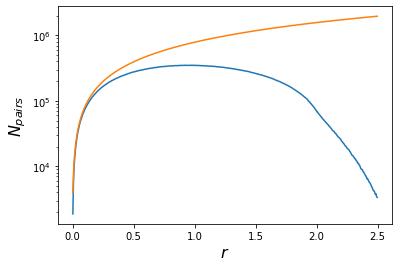

In [25]:
hist, be = np.histogram(distances, range=(0,2.5), bins=500)
sep_dist = 0.5*(be[1:]+be[:-1])
dsep = sep_dist[1]-sep_dist[0]
N_dist = 10000*10000/4*np.pi*(2*sep_dist*dsep+dsep**2)
plt.plot(sep_dist, hist*2.0, label='Counted randoms') # We multiply times 2 because in the formula we are double-counting but in our computations we weren't to speed-up the process
plt.plot(sep_dist, N_dist, label='Expected number of pairs')
plt.yscale('log')
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$N_{pairs}$', fontsize=16)

### Extending to Higher Dimensions

If, instead we were in a 3D space, the number of particles in a sphere would grow as $r^{3}$, and if we were in another type of geometry we would have that the number of particles grows as $r^{D}$, where $D$ is the dimensionality of our geometry (if $D$ is not integer we say that we are in a fractal geometry). 

Clearly counting particles in a volume can give us information about properties in the "Universe" so, what happens with galaxies? Are they randomly placed?

## Exercise

Let's check for our SDSS sample. First re-load that initial sample from DR14 (the first query)

In [23]:
all_gals #Check you have the sample you think 
print("My sample has " + str(len(all_gals))+ " galaxies")

My sample has40332 galaxies


Now we need a random sample with the same "survey shape" (limits in RA, Dec and $z$) as the real survey. 

  You should be able to see from the plots though that this includes parts of the sky with no data. In a real measurement you would take time to make a random sample with actual complicated edges in RA and Dec. For this exercise just cut out an RA, Dec range which makes an exact box. 
  
 And pick a narrow range of redshifts to give you about 10,000 galaxies. 

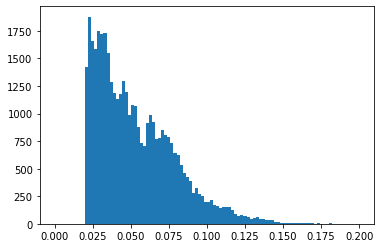

In [28]:
plt.hist(all_gals['z'],range=[0,0.2],bins=100); #A quick histogram will help pick the redshift range

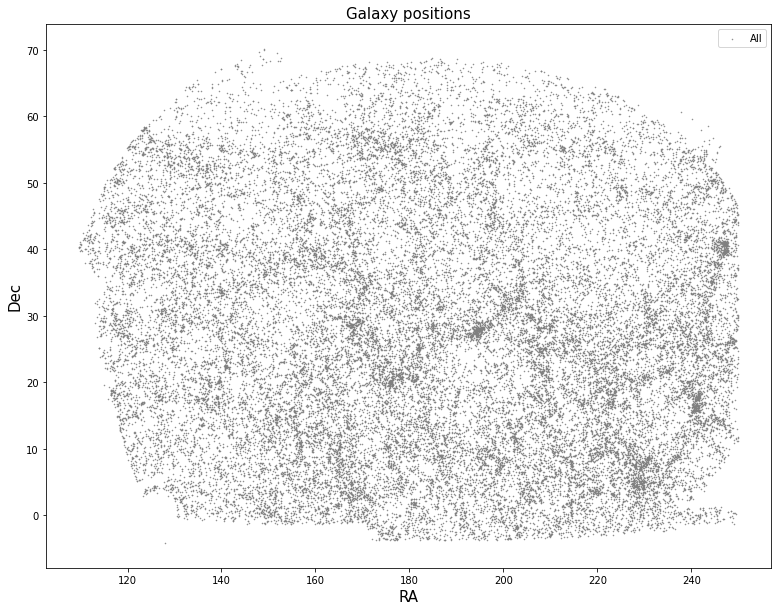

In [29]:
# A sky plot to find good RA and Dec limits
plt.figure(figsize=(13,10))
plt.scatter(all_gals['ra'], all_gals['dec'], marker='.', color='grey',s=1,label="All")
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)

In [ ]:
#Code to put your limits in

decmin=NUMBER HERE
decmax=NUMBER HERE
ramin=NUMBER HERE
ramax=NUMBER HERE
zmin=NUMBER HERE
zmax=NUMBER HERE

SDSS_nicebox = (all_gals['dec'] > decmin) & (all_gals['dec'] < decmax) &  (all_gals['ra'] > ramin)  & (all_gals['ra'] < ramax) & (all_gals['z'] > zmin) & (all_gals['z'] < zmax)

print("Selection includes " + str(len(all_gals[SDSS_nicebox]))+ " galaxies")

plt.figure(figsize=(13,10))
#plt.scatter(all_gals['ra'], all_gals['dec'], marker='.', color='grey',s=1,label="All")
plt.scatter(all_gals[SDSS_nicebox]['ra'], all_gals[SDSS_nicebox]['dec'], marker='x', color='red',s=1,label='Nice box')
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)
plt.legend()

Now let's make a random sample with the same limits in RA, Dec

In [ ]:
Nrnd = 10000
RArnd = ramin+(ramax-ramin)*np.random.random(size=Nrnd)
Decrnd = decmin+(decmax-decmin)*np.random.random(size=Nrnd)

plt.scatter(RArnd, Decrnd, s=0.1, marker='.')

Now we do the measurements on both the real data, and the random sample.

In [32]:
galaxy_distances = []
x = np.array(all_gals[SDSS_nicebox]['ra']) #Need to make these Numpy arrays for the code to work
y = np.array(all_gals[SDSS_nicebox]['dec'])
Ng = 1.0*len(x)
for i in range(x.size):
    galaxy_distances.append(np.sqrt((x[i+1:]-x[i])**2+
                                    (y[i+1:]-y[i])**2))
galaxy_distances = np.concatenate(galaxy_distances)

In [33]:
random_distances = []
x = RArnd  
y = Decrnd
Nrnd = 1.0*len(x)
for i in range(x.size):
    random_distances.append(np.sqrt((x[i+1:]-x[i])**2+
                                    (y[i+1:]-y[i])**2))
random_distances = np.concatenate(random_distances)

In [ ]:
#Plot the histogram of pairs with separation distances between 0-100 degrees compared to the random sample
plt.hist(galaxy_distances, range=(0, 100), bins=100, histtype='step', density=True, label='Galaxy')
plt.hist(random_distances, range=(0, 100), bins=100, histtype='step', density=True, label='Random')
plt.xlabel('Separation distance [degrees]', fontsize=16)
plt.ylabel('Number of pairs', fontsize=16)
plt.legend(loc='best')

As we discovered above, the distance where the random sample starts to have smaller numbers of pairs reveals the max separation you can use in this box to make this measurement well. 

## Exercise 

Redo the plot with a better limit on separation

The correlation function is just the ratio of these histograms (well, the ratio minus 1)! 

In [ ]:
smax=30 #Quick way to change max separation considered, since it appears in multiple places
nbins=100 #Same for number of bins
ng, bin_edges = np.histogram(galaxy_distances, range=(0, smax), bins=nbins)
nr, bin_edges = np.histogram(random_distances, range=(0, smax), bins=nbins)
ng = ng*2.0
nr = nr*2.0 # This is because we have the pair ij but also the pair ji
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.plot(bin_centers, Nrnd**2/Ng**2*ng/nr-1) #Correlation function calculation in the plotting command
plt.axhline(0, ls='--', c='k')
plt.xlabel(r'Separation distance, $\theta$ [deg]', fontsize=16)
plt.ylabel(r'Correlation function, $w(\theta)$', fontsize=16)

In [ ]:
#Plot showing smaller separations
plt.plot(bin_centers, Nrnd**2/Ng**2*ng/nr-1)
plt.axhline(0, ls='--', c='k')
plt.xlim(0,10)
plt.xlabel(r'Separation distance, $\theta$ [deg]', fontsize=16)
plt.ylabel(r'Correlation function, $w(\theta)$', fontsize=16)

This way to compute the correlation function is using the so-called, natural estimator (see more [here](https://arxiv.org/pdf/astro-ph/9912088.pdf)):

$$w_{N}(\theta) = \frac{N_{r}}{N_{g}}\frac{DD(\theta)}{RR(\theta)} - 1$$

Where $DD(\theta)$ is the number of galaxy (data) pairs at a distance $\theta$ (so each of the entries of the histogram of `galaxy_distances`), and $RR(\theta)$ is the number of random pairs at a distance $\theta$, $N_{g}$ is the total number of galaxies in the considered catalog (in our case our redshift slice) and $N_{r}$ the number of randoms points in the random catalog (in our case our redshift slice). 

The correlation function tells us the excess probability of finding a pair of objects at a certain distance compared to a random distribution. It is usually written as $\xi(r)$ (in 3D, when you have accurate redshift measurements) or $w(\theta)$ (in 2D, as in our case when we use a thin slice in redshift).

You might be able to see that computing the correlation function this way is a slow process -- $\mathcal{O}(N^{2})$ -- that is why with big surveys, astronomers use some computational tricks to speed up this calculation. 

The most commonly used estimator of the correlation function is galaxy surveys is the [Landy & Szalay estimator](http://articles.adsabs.harvard.edu/pdf/1993ApJ...412...64L). In the graph below you can see that both the galaxy bins and the random bins fluctuate a little bit due to the fact that we have a finite number of galaxies and random particles to compute our correlation function. Since we are dividing two noisy quantities, fluctuations may become enhanced. In order to avoid this, we add another term to the calculation, which is the distribution of distances between galaxies and random particles, $DR(\theta)$:

$$w_{LS}(\theta) = \frac{N_{rnd}^{2}}{N_{gal}^{2}}\frac{DD(\theta)}{RR(\theta)}-2\frac{N_{rnd}}{N_{g}}\frac{DR(\theta)}{RR(\theta)} + 1$$

In [19]:
galaxy_random_distances = []
x = np.array(all_gals[SDSS_nicebox]['ra']) #Need to make these Numpy arrays for the code to work
y = np.array(all_gals[SDSS_nicebox]['dec'])
xr = RArnd  
yr = Decrnd
for i in range(x.size):
    galaxy_random_distances.append(np.sqrt((xr-x[i])**2+
                                    (yr-y[i])**2))
galaxy_random_distances = np.concatenate(galaxy_random_distances)

In [20]:
nrg, bin_edges = np.histogram(galaxy_random_distances, range=(0, smax), bins=nbins) 
#Check what smax and nbins are

Code to compare the two estimators

In [ ]:
plt.plot(bin_centers, Nrnd**2/Ng**2*ng*1.0/nr-1, label='Natural estimator')
plt.plot(bin_centers, Nrnd**2/Ng**2*ng*1.0/nr-2*Nrnd/Ng*nrg*1.0/nr+1, label='LS estimator')
plt.axhline(0, ls='--', c='k')
plt.xlabel(r'Separation distance, $\theta$ [deg]', fontsize=16)
plt.ylabel(r'Correlation function, $w(\theta)$', fontsize=16)
plt.xlim(0,10)
plt.legend()

### Extension Ideas

1. Can you compute the 3D correlation function in this sample? 
2. Compute correlation functions for subsampels - like red/blue galaxies, or spirals/ellipticals. What differences do you expect. What differences do you notice? 